# EXERCISE 4


### AIM:
    1. Check and change the action space and change uncertainty levels.
    2. Visualize model convergence on tensorboard.  
    3. Analyse the saved model to evaluate performance.
    4. Discussion on suitable design of actions space and obervations.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd './drive/MyDrive/Exercises/Exercise 04'

/content/drive/MyDrive/Exercises/Exercise 04


Installing required packages and libraries

In [3]:
!pip install stable-baselines3
!pip install shimmy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 14.1 MB/s eta 0:00:00


In [4]:
import gymnasium
import os
import math
import pandas as pd
import numpy as np
import seaborn as sb
from shapely import geometry
import geopandas as gpd
from gymnasium import spaces
from PIL import Image
from shapely.geometry import LineString, Point
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas


In [5]:
%load_ext tensorboard

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Reading the additional data sources
####  Changes to these files and analysis are not required. These are helper files to create the desired environment and conflict scenarios. The data is in the form of longitudes and latitudes. We transform them into x, y co-ordinates.
#### The files are:
    - test.geojson : to plot sector 6 of the Singapore FIR
    - path_Waypoints22feb: file containing a list of waypoints
    - 22feb_paths

In [6]:
df = gpd.read_file('test.geojson')
poly = df.geometry[5]
x, y = poly.exterior.coords.xy
xx = np.array(x)
yy = np.array(y)

# concatenating lat lons from two file to see the actual range for transformation
wpfile = pd.read_csv('path_Waypoints22feb.csv')
# print(wpfile.columns)
wps = pd.DataFrame(wpfile[['NAME','LAT', 'LON']])
lon = wps[['LON']].to_numpy()
lat = wps[['LAT']].to_numpy()
lon = lon.ravel()
lat = lat.ravel()
lon_array = np.concatenate((xx, lon))
lat_array = np.concatenate((yy, lat))

max(lon_array),min(lon_array), max(lat_array), min(lat_array)


def rescaling(r_min, r_max,m, t_min = 0, t_max = 100):
    """rescaling given the r_min and r_max (current range) and T_min and t_max of target range, and the measurement m """
    delta_r = r_max - r_min
    delta_t = t_max - t_min
    scaled = (m - r_min)*(delta_t)/delta_r + t_min
    return scaled

sector_X = []
sector_Y = []
for i in range(len(x)):
    x_ = rescaling(min(lon_array), max(lon_array), x[i])
    y_ = rescaling(min(lat_array), max(lat_array), y[i])
    sector_X.append(x_)
    sector_Y.append(y_)

waypoints_X = []
waypoints_Y = []
for i in range(len(wps)):
    x_ = rescaling(min(lon_array), max(lon_array), wps.iloc[i]['LON'])
    y_ = rescaling(min(lat_array), max(lat_array),  wps.iloc[i]['LAT'])
    waypoints_X.append(x_)
    waypoints_Y.append(y_)

pathfile = pd.read_csv('22feb_paths')
pathfile  = pathfile.drop(['ROUTE_NAME','SID', 'STAR', 'Unnamed: 10'], axis = 1).reset_index(drop = True)
pathfile = pathfile.drop([])
pathfile

w = wps['NAME'].to_list()
namedata = pd.DataFrame(data = zip(w, waypoints_X, waypoints_Y), columns = ['name', 'X', 'Y'])
namedata = namedata.round(2)
namedata

# path1, path2, path3, path4, path5, path6 = [], [], [], [], [], []
pathlist = []
for i in range(len(pathfile)):
    path = []
    for j in range(len(pathfile.loc[i])):
        for k in range(len(namedata)):
            if pathfile.loc[i][j] == namedata.loc[k]['name']:
                path.append([namedata.loc[k]['X'], namedata.loc[k]['Y']])
    pathlist.append(path)

Visualizing the transformed sector and the airways

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


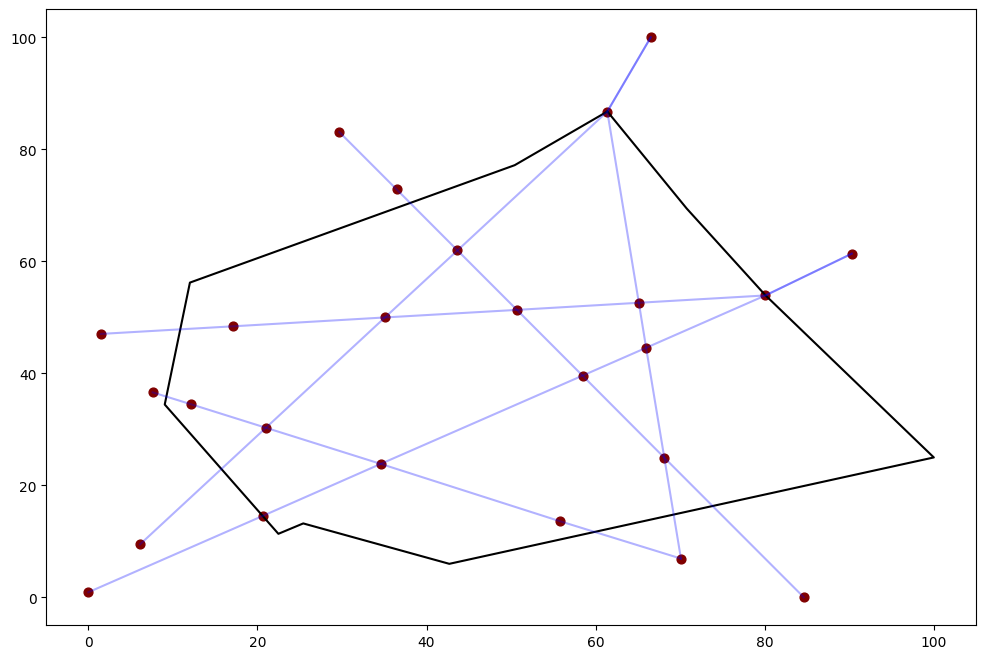

In [7]:
fig,ax = plt.subplots(figsize = (12,8))
plt.plot(sector_X, sector_Y, color = 'black')
plt.scatter(waypoints_X, waypoints_Y, c='maroon',s =40, alpha = 1)
speed = 2.5
x, y  = pathlist[2][0][0], pathlist[2][0][1]
# heading = 0.73 +np.pi
# heading = np.pi*1.25
# x_, y_ = x + speed*np.cos(heading), y + speed *np.sin(heading)
# x3, y3 = x_ + speed*np.cos(heading), y_ + speed *np.sin(heading)
# plt.scatter(x,y, color = 'red', s = 40)
# plt.scatter(x_, y_, color = 'red', s = 40)
# plt.scatter(x3, y3, color = 'red', s = 40)

for i in range(len(pathlist)):
    x = []
    y = []
    for j in range(len(pathlist[i])):
        x.append(pathlist[i][j][0])
        y.append(pathlist[i][j][1])
    plt.plot(x, y, color = 'blue', alpha  = 0.3)
    # plt.scatter(Own_positionlist[0], Own_positionlist[1])


The code below is additional code to generate the conflict of two pre-defined airways in the sector. This should not be changed.

In [8]:
slopelist1 = []
headinglist1 = []
path1 = pathlist[2]
for i in range(1,len(path1)):
    position1 = np.array(path1[i-1])
    position2 = np.array(path1[i])
    # print(position1, position2)
    slope = np.round((position2[1] - position1[1]) / (position2[0] - position1[0]),2)
    # print(slope)
    slopelist1.append(slope)

# distance that the agent will move withthe specified speed
position1 = pathlist[0][0]
slop = -1.5
speed = 2.5
p2x = position1[0] + (speed * slope)
p2y = position1[1] + (speed * slope)
position2 = [p2x, p2y]

np.round(math.dist(position1, position2),2)


def agentposition(waypointlist, speed):
    agentpositionlist = []
    for i in range(1, len(waypointlist)):
        startpoint_init = waypointlist[i-1]
        agentpositionlist.append(np.array(startpoint_init))
        endpoint = waypointlist[i]
        endpoint_poly = geometry.Point(endpoint[0], endpoint[1])
        buffer = 2.5 # raiuds of circle to check in or out
        circlebuffer = endpoint_poly.buffer(buffer)
        startpoint = waypointlist[i-1]

        for j in range(100): # 50 is a random number here
            totaldist = math.dist(endpoint, startpoint)
            s =  speed
            ratio = speed / totaldist
            p0 = startpoint[0]*(1- ratio) + ratio* endpoint[0]
            p1 = startpoint[1] * (1- ratio) + ratio * endpoint[1]
            position_ = [p0, p1]
            agentpositionlist.append(np.round(position_,2))
            startpoint = position_
            point2_poly = geometry.Point(startpoint)
            if circlebuffer.contains(point2_poly):
                break

    return agentpositionlist

ownwaypoints = pathlist[2]
ownwaypoints
linestringOwn = LineString(ownwaypoints)
linestringOwn

Own= agentposition(pathlist[2], 2.5)
Int1 = agentposition(pathlist[0], 2.5)
Int2 = agentposition(pathlist[1], 2.5)
# print(len(Own), len(Int1), len(Int2))
import copy

Own_positionlist = copy.deepcopy(Own)
Int_positionlist1 = copy.deepcopy(Int1)
Int_positionlist2 = copy.deepcopy(Int2)

#pairwise_offsets
def pairwise_offsets(onwlist, intlist):
    offsetlist = []
    onwindex = 0
    intindex = 0
    for i in range(len(onwlist)):
        for j in range(len(intlist)):
            if onwlist[i][0] == intlist[j][0] and onwlist[i][1] == intlist[j][1]:
                print(i, j)
                onwindex = i
                intindex = j
                break
    if onwindex > intindex: # onwship take more steps, add offset to intruder
        # print('Yes')
        delta = onwindex - intindex
        # print(delta)
        offsetlist.append(0)
        offsetlist.append(delta)
    else:
        delta = intindex - onwindex
        offsetlist.append(delta)
        offsetlist.append(0)
    return offsetlist

list1 = pairwise_offsets(Own_positionlist, Int_positionlist1)
list2 = pairwise_offsets(Own_positionlist, Int_positionlist2)


19 17
26 25



## Task 1:


### Uncertaintiy can be added in terms of noise to the position of the Ownship aircraft at each step.


### Uncertainty can also be added to the heading of the Ownship inside the step function to emulate the weather related variations etc.

Creating the Agent Class

In [ ]:
# offsetlist = [0, 2, 1]

class Ownship():
    def __init__(self, path, wp_linestring,  offset):
        self.start_time = 0
        self.pathlist = tuple(copy.deepcopy(path))
        self.position  = path[0]
        self.speed = 2.5
        self.heading = np.pi + 0.73 # fixing the initial heading and path of ownship pathlist[2]. 0.73 is the initial slope
        self.new_path = []
        self.offset = offset
        self.wp_linestring = wp_linestring
        self.int1dist = []
        self.CTD = []
        self.num_actions = 0

    def step(self, new_heading):
        # if n_step <= self.offset:
        #     return self.position
        self.heading = new_heading
        # print('original position', self.position)
        self.position[0] = np.clip((self.position[0] + self.speed*np.cos(new_heading)), 0, 100)
        self.position[1] = np.clip((self.position[1] + self.speed*np.sin(new_heading)), 0, 100)
        # print('ownship position after agent step function', self.position)
        return self.position


class Intruder():
    def __init__(self, path, offset):
        self.pathlist  = tuple(copy.deepcopy(path))
        self.speed = 2.5
        self.position = path[0]
        self.done = False
        self.offset = offset

    def step(self, n_step):
        if n_step >= len(self.pathlist):
            return self.position

        if n_step <= self.offset:
            return self.position

        self.position[0] = self.pathlist[n_step- self.offset][0]
        self.position[1] = self.pathlist[n_step- self.offset][1]
        return self.position


def heading(point1, point2): #calculations relative to x axis
    delta_y =point2[1] - point1[1]
    delta_x =  point2[0] - point1[0]
    if delta_x == 0:
        delta_x = 0.005

    slope = np.round((delta_y) / (delta_x), 3)

    if point2[1] > point1[1] and point2[0] > point1[0]: #first quadrant
        head =  slope
    elif point2[1] > point1[1] and point2[0] <point1[0]: #second quadrant
        head = 0.5*np.pi + slope
    elif point2[1] < point1[1] and point2[0] < point1[0]: #third quadrant
        head = np.pi + slope
    elif point2[1] < point1[1] and point2[0] > point1[0]:
        head = 1.5 * np.pi + slope
    elif point2[1] - point1[1] == 0 and point2[0] < point1[0]:
        head = np.pi + slope
    else:
        head = slope


    return head



### Task 1 (continued)
#### Creating the Sector 6 Environment:

The step function has a list of actions. We can change the number of actions from step of 5 degrees to steps of 10 Degrees.


In [ ]:

class StructuredEnv(gymnasium.Env):
    SAFE_R = 5

    ALPHA = 0.1 * np.pi
    MAX_STEP = 60

    def __init__(self, Reward_Params= [-1, -1, -1, -1, -1, 1]):
        self.Reward_Params = Reward_Params
        self.agents = [Ownship(copy.deepcopy(Own),linestringOwn, 0), Intruder(copy.deepcopy(Int1), 2)]

        self.reward = 0
        self.n_step = 0
        self.total_reward = 0
        n_observations = np.size(self.observation_func())
        n_action = 1

        self.action_space = spaces.Discrete(17)
        self.observation_space = spaces.Box(low = -100, high = 120, shape= (n_observations, ), dtype = np.float64)

    def reset(self, seed = 0):
        self.agents = [Ownship(copy.deepcopy(Own),linestringOwn, 0), Intruder(copy.deepcopy(Int1), 2)]
        # self.agents = [Ownship(copy.deepcopy(Own), 0)]
        self.reward = 0
        self.n_step = 0
        self.total_reward = 0

        observation = self.observation_func()

        return observation, {}

    def step(self, action):
        self.n_step += 1
        # print('env step', self.n_step)

        for i in range(len(self.agents)):
            x, y = self.agents[i].position
            speed = self.agents[i].speed
            if i == 0:
                heading = self.agents[i].heading
                # print('action', action)
                # print('heading' , heading)
                if action == 0:
                    angle = -0.028 *np.pi # 5 degree
                if action == 1:
                    angle = -0.056 *np.pi # 10 degree
                if action == 2:
                    angle = -0.0835 *np.pi # 15deg
                if action == 3:
                    angle = -0.111 *np.pi # 20 deg
                if action == 4:
                    angle = -0.139 *np.pi  # 25 deg
                if action == 5:
                    angle = -0.167 *np.pi  #30 deg
                if action == 6:
                    angle = -0.1945 *np.pi  # 35deg
                if action == 7:
                    angle = -0.222 *np.pi  # 40deg
                if action == 8:
                    angle = 0
                if action == 9:
                    angle = 0.028 *np.pi # 5 degree
                if action == 10:
                    angle = 0.056 *np.pi # 10 degree
                if action == 11:
                    angle = 0.0835 *np.pi # 15deg
                if action == 12:
                    angle = 0.111 *np.pi # 20 deg
                if action == 13:
                    angle = 0.139 *np.pi  # 25 deg
                if action == 14:
                    angle = 0.167 *np.pi  #30 deg
                if action == 15:
                    angle = 0.1945 *np.pi  # 35deg
                if action == 16:
                    angle = 0.222 *np.pi  # 40deg


                heading = heading + angle
                # heading = heading + angle + np.random.choice([-0.028, 0.028]) #adding uncertainty

                # print(heading)
                self.agents[i].step(heading) # new location for ownship
                self.agents[i].new_path.append(np.array(self.agents[i].position))
                if action == 8:
                    self.agents[i].num_actions +=0
                else:                                #counting number of actions
                    self.agents[i].num_actions +=1

            else:
                self.agents[i].step(self.n_step)
        dis1 = np.linalg.norm(self.agents[0].position - self.agents[1].position)
        self.agents[0].int1dist.append(dis1)

        self.done  = self.check_stopping_condition()
        self.reward = self.reward_func(action, self.done)
        observation = self.observation_func()
        self.total_reward += self.reward

        info = {}
        return observation, self.reward, self.done, False, info

    def check_stopping_condition(self):
        done = False
        x, y = self.agents[0].position

        x_thresh = self.agents[0].pathlist[-1][0]
        y_thresh = self.agents[0].pathlist[-1][1]

        dist = np.linalg.norm(self.agents[0].position - np.array([x_thresh, y_thresh]))
        if (dist < 2) or (self.n_step >= self.MAX_STEP) or self.agents[0].position[0] <= x_thresh :
            return True

        dis1 = np.linalg.norm(self.agents[0].position - self.agents[1].position)

        if (dis1 < self.SAFE_R):
            return True

        return False


    def reward_func(self, action, done):
        """
        Reward = a1 * Reward_Step (-ve) +
                 a2 * Reward_Deviation (-ve) +
                 a3 * Reward_LOS (-ve) +
                 a4 * Reward_Maneuvering(-ve) +
                 a5 * Reward_Not_Reached (-ve)+
                 a6 * Reward_Reached (+ve)
        """
        a1 = self.Reward_Params[0]
        a2 = self.Reward_Params[1]
        a3 = self.Reward_Params[2]
        a4 = self.Reward_Params[3]
        a5 = self.Reward_Params[4]
        a6 = self.Reward_Params[5]

        ####################


        Reward_Step = 0.2


        # terminal location: x_thresh, y_thresh
        x_thresh = self.agents[0].wp_linestring.coords[-1][0]
        y_thresh = self.agents[0].wp_linestring.coords[-1][1]
        terminal_location = np.array([x_thresh, y_thresh])

        Moving_back_reward = 0
        mergingreward = 0
        CTDreward = 0
        CTD_merge_reward = 0

        current_location = Point(self.agents[0].position)
        CTD_distance  = current_location.distance(self.agents[0].wp_linestring)
        self.agents[0].CTD.append(CTD_distance)
        CTDreward = 8* (CTD_distance/100)

        if self.n_step < 2:
            Moving_back_reward = 0

        else:
            previous_location = self.agents[0].new_path[-2]
            current_location = self.agents[0].position

            prev_distance = np.linalg.norm(terminal_location - previous_location)
            current_distance = np.linalg.norm(terminal_location - current_location)
            if current_distance >= prev_distance:
                Moving_back_reward =  20
            else:
                Moving_back_reward = -0.06 # this will become positive reward since the reward_param is negative for this


        Reward_Deviation = CTDreward + Moving_back_reward


        Reward_LOS = 0
        Reward_Maneuvering = 0
        Reward_Not_Reached = 0
        Reward_Reached =0
        dis1 = np.linalg.norm(self.agents[0].position - self.agents[1].position)

        Reward_LOS = 0
        if (dis1 < self.SAFE_R*2):
            Reward_LOS = 150
        Reward_num_actions = 0.01 # given at each step so kept small
        Reward_num_actions_total = 0
        if done:
            x_thresh = self.agents[0].wp_linestring.coords[-1][0]
            y_thresh = self.agents[0].wp_linestring.coords[-1][1]
            terminal_location = np.array([x_thresh, y_thresh])
            if self.n_step == self.MAX_STEP:
                current_location = self.agents[0].position
                dist = np.linalg.norm(terminal_location - current_location)
                Reward_Not_Reached = 1.5*(dist/100)
            else:
                Reward_Reached = 80

            Reward_num_actions_total =  self.agents[0].num_actions


        reward = a1 * Reward_Step + a2 *Reward_Deviation + a3 * Reward_LOS + a4 * Reward_Maneuvering + \
                    a5 * Reward_Not_Reached + a6 * Reward_Reached + (-Reward_num_actions) + 2*(-Reward_num_actions_total)
        return reward

    def observation_func(self):
        observation  = []
        dist1 = np.linalg.norm(self.agents[0].position - self.agents[1].position) # ownship and intruder1
        x_thresh = self.agents[0].wp_linestring.coords[-1][0]
        y_thresh = self.agents[0].wp_linestring.coords[-1][1]
        terminal_location = np.array([x_thresh, y_thresh])
        dist3 = np.linalg.norm(self.agents[0].position - terminal_location)
        observation.append(dist1)
        observation.append(dist3)
        current_location = Point(self.agents[0].position)
        CTD_distance  = current_location.distance(self.agents[0].wp_linestring)
        observation.append(CTD_distance) # dist of ownship from the original path

        # initial distance
        dis1 = np.linalg.norm(self.agents[0].position - self.agents[1].position)
        int1dist_observation = dis1
        if self.n_step <= 2:
            # print(self.n_step)
            int1dist_observation = - dis1
            # int2dist_observation = - dis2

        if 2 < self.n_step < len(self.agents[0].pathlist):
            if self.agents[0].int1dist[self.n_step-1] < self.agents[0].int1dist[self.n_step - 2]: #- ve magnitude i.e converging
                int1dist_observation = - self.agents[0].int1dist[self.n_step -1]
            else: # positive magnitude i.e diverging
                int1dist_observation =  self.agents[0].int1dist[self.n_step - 1]

        if self.n_step > len(self.agents[0].pathlist):
            int1dist_observation =  self.agents[0].int1dist[-1]

        observation.append(int1dist_observation)

        observation = np.array(observation)
        return observation


    def render(self, show = False, folder = './Images/'):
        fig, ax = plt.subplots(figsize = (14, 11))
        plt.plot(sector_X, sector_Y, color = 'black')
        plt.scatter(waypoints_X, waypoints_Y, c='maroon',s =20, alpha = 1)
        plt.scatter(self.agents[0].wp_linestring.coords[-1][0], self.agents[0].wp_linestring.coords[-1][1], c='blue',s =100, alpha = 1, marker= '*')
        for i in range(len(self.agents[0].pathlist)):
            plt.plot(self.agents[0].pathlist[i][0], self.agents[0].pathlist[i][1] ,color= 'red')

        for i in range(len(pathlist)):
            x = []
            y = []
            for j in range(len(pathlist[i])):
                x.append(pathlist[i][j][0])
                y.append(pathlist[i][j][1])
            ax.plot(x, y, color = 'blue', alpha  = 0.3)

        for i in range(len(self.agents)):
            x, y = self.agents[i].position
            if i == 0:
                ax.scatter(x, y, c='blue', s = 60)
            else:
                ax.scatter(x,y, c='red', s = 60)
            ax.set_title("Step {} - Reward {:.3f} - Total Reward {:.3f}".format(self.n_step,self.reward,self.total_reward))

        if show:
            plt.show()
        else:
            plt.savefig(folder + "image_{:0>3}.png".format(self.n_step))
            print(folder + "image_{:0>3}.png".format(self.n_step))

        return fig

    def close(self):
        pass




In [ ]:
from stable_baselines3.common.env_checker import check_env

structured_env = StructuredEnv()
# It will check your custom environment and output additional warnings if needed

check_env(structured_env)

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


./Images/image_000.png


<bound method StructuredEnv.close of <__main__.StructuredEnv object at 0x7931f475a4d0>>

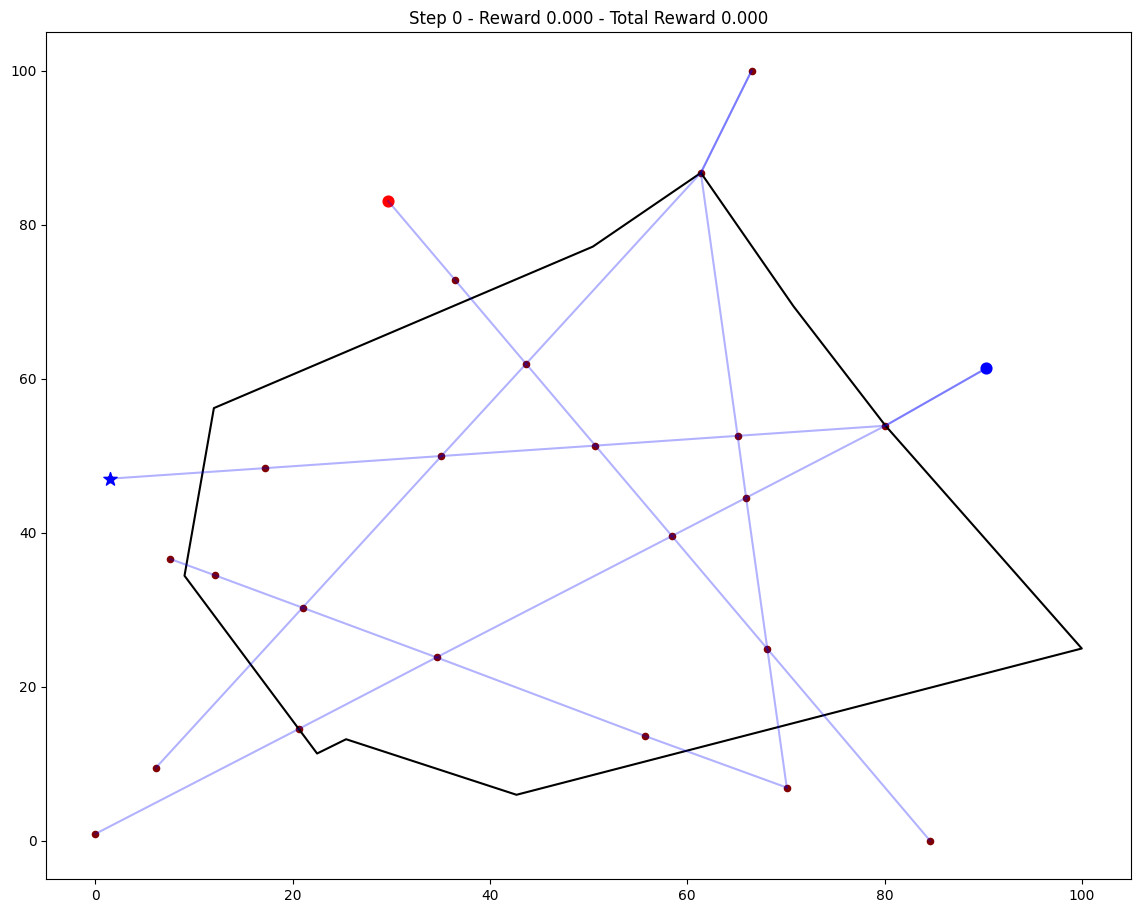

In [ ]:
structured_env.reset()
structured_env.render()
structured_env.close

In [ ]:
structured_env.reset()
structured_env.observation_func()

array([ 64.39365497,  89.95868496,   0.        , -64.39365497])

In [ ]:
structured_env.observation_space

Box(-100.0, 120.0, (4,), float64)

## Task 2

### Train the agent and visualize the convergence on tensorboard

In [9]:
import os
os.getcwd()

'/content/drive/MyDrive/Exercises/Exercise 04'

In [12]:
%tensorboard --logdir=./Logs/CustomEnv/ --host=localhost --port=8081

Reusing TensorBoard on port 8081 (pid 895), started 0:00:14 ago. (Use '!kill 895' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy

Reward_Params= [-1, -1, -1, -1, -1, 1]

# name = 'structured_env_PPO_2ac_8sept2023'
# from stable_baselines3.ppo import MlpPolicy
# from stable_baselines3 import PPO
# model = PPO(MlpPolicy, structured_env ,gamma=0.99, tensorboard_log='./Logs/CustomEnv/', verbose = 1)

name = 'structured_env_DQN'
from stable_baselines3.dqn import MlpPolicy
from stable_baselines3 import DQN
model = DQN(MlpPolicy, structured_env ,gamma=0.99, tensorboard_log='./Logs/CustomEnv/', verbose = 1)



eval_env = StructuredEnv(Reward_Params)

eval_callback = EvalCallback(eval_env, best_model_save_path='./log/PPO/',
                             log_path='./log/PPO/', eval_freq=5000,
                             deterministic=True, render=False)
model.learn(total_timesteps=500000, tb_log_name=name, callback=eval_callback, progress_bar = True)
# model.learn(total_timesteps=100000, tb_log_name=name)

model.save("./Models/CustomEnv/" +name)

# Evaluate the trained model
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./Logs/CustomEnv/structured_env_DQN_2


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.8     |
|    ep_rew_mean      | -603     |
|    exploration_rate | 0.997    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 345      |
|    time_elapsed     | 0        |
|    total_timesteps  | 159      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.1     |
|    ep_rew_mean      | -554     |
|    exploration_rate | 0.994    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 361      |
|    time_elapsed     | 0        |
|    total_timesteps  | 321      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46.8     |
|    ep_rew_mean      | -594     |
|    exploration_rate | 0.989    |
| time/               |          |
|    episodes       

Eval num_timesteps=5000, episode_reward=-1091.68 +/- 0.00

Episode length: 44.00 +/- 0.00

-----------------------------------
| eval/               |           |
|    mean_ep_length   | 44        |
|    mean_reward      | -1.09e+03 |
| rollout/            |           |
|    exploration_rate | 0.905     |
| time/               |           |
|    total_timesteps  | 5000      |
-----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 53.7     |
|    ep_rew_mean      | -785     |
|    exploration_rate | 0.902    |
| time/               |          |
|    episodes         | 96       |
|    fps              | 679      |
|    time_elapsed     | 7        |
|    total_timesteps  | 5155     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 53.8     |
|    ep_rew_mean      | -784     |
|    exploration_rate | 0.898    |
| time/               |          |
|    episodes         | 100      |
|    fps              | 695      |
|    time_elapsed     | 7        |
|    total_timesteps  | 5379     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54.5     |
|    ep_rew_mean      | -783     |
|    exploration_rate | 0.893    |
| time/               |          |
|    episodes       

Eval num_timesteps=10000, episode_reward=-1091.68 +/- 0.00

Episode length: 44.00 +/- 0.00

-----------------------------------
| eval/               |           |
|    mean_ep_length   | 44        |
|    mean_reward      | -1.09e+03 |
| rollout/            |           |
|    exploration_rate | 0.81      |
| time/               |           |
|    total_timesteps  | 10000     |
-----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 55       |
|    ep_rew_mean      | -904     |
|    exploration_rate | 0.806    |
| time/               |          |
|    episodes         | 188      |
|    fps              | 912      |
|    time_elapsed     | 11       |
|    total_timesteps  | 10217    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54.9     |
|    ep_rew_mean      | -893     |
|    exploration_rate | 0.802    |
| time/               |          |
|    episodes         | 192      |
|    fps              | 916      |
|    time_e

Eval num_timesteps=15000, episode_reward=-1091.68 +/- 0.00

Episode length: 44.00 +/- 0.00

-----------------------------------
| eval/               |           |
|    mean_ep_length   | 44        |
|    mean_reward      | -1.09e+03 |
| rollout/            |           |
|    exploration_rate | 0.715     |
| time/               |           |
|    total_timesteps  | 15000     |
-----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 53.4     |
|    ep_rew_mean      | -852     |
|    exploration_rate | 0.713    |
| time/               |          |
|    episodes         | 280      |
|    fps              | 961      |
|    time_elapsed     | 15       |
|    total_timesteps  | 15129    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 53.7     |
|    ep_rew_mean      | -854     |
|    exploration_rate | 0.708    |
| time/               |          |
|    episodes         | 284      |
|    fps              | 961      |
|    time_e

Eval num_timesteps=20000, episode_reward=-1091.68 +/- 0.00

Episode length: 44.00 +/- 0.00

-----------------------------------
| eval/               |           |
|    mean_ep_length   | 44        |
|    mean_reward      | -1.09e+03 |
| rollout/            |           |
|    exploration_rate | 0.62      |
| time/               |           |
|    total_timesteps  | 20000     |
-----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 55       |
|    ep_rew_mean      | -908     |
|    exploration_rate | 0.617    |
| time/               |          |
|    episodes         | 372      |
|    fps              | 1048     |
|    time_elapsed     | 19       |
|    total_timesteps  | 20161    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 55       |
|    ep_rew_mean      | -902     |
|    exploration_rate | 0.613    |
| time/               |          |
|    episodes         | 376      |
|    fps              | 1053     |
|    time_e

Eval num_timesteps=25000, episode_reward=-1091.68 +/- 0.00

Episode length: 44.00 +/- 0.00

-----------------------------------
| eval/               |           |
|    mean_ep_length   | 44        |
|    mean_reward      | -1.09e+03 |
| rollout/            |           |
|    exploration_rate | 0.525     |
| time/               |           |
|    total_timesteps  | 25000     |
-----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 52.8     |
|    ep_rew_mean      | -831     |
|    exploration_rate | 0.524    |
| time/               |          |
|    episodes         | 464      |
|    fps              | 1127     |
|    time_elapsed     | 22       |
|    total_timesteps  | 25036    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 52.4     |
|    ep_rew_mean      | -847     |
|    exploration_rate | 0.521    |
| time/               |          |
|    episodes         | 468      |
|    fps              | 1131     |
|    time_e

Eval num_timesteps=30000, episode_reward=-1091.68 +/- 0.00

Episode length: 44.00 +/- 0.00

-----------------------------------
| eval/               |           |
|    mean_ep_length   | 44        |
|    mean_reward      | -1.09e+03 |
| rollout/            |           |
|    exploration_rate | 0.43      |
| time/               |           |
|    total_timesteps  | 30000     |
-----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 56.6     |
|    ep_rew_mean      | -904     |
|    exploration_rate | 0.426    |
| time/               |          |
|    episodes         | 556      |
|    fps              | 1193     |
|    time_elapsed     | 25       |
|    total_timesteps  | 30226    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 56.5     |
|    ep_rew_mean      | -904     |
|    exploration_rate | 0.421    |
| time/               |          |
|    episodes         | 560      |
|    fps              | 1196     |
|    time_e

Eval num_timesteps=35000, episode_reward=-1091.68 +/- 0.00

Episode length: 44.00 +/- 0.00

-----------------------------------
| eval/               |           |
|    mean_ep_length   | 44        |
|    mean_reward      | -1.09e+03 |
| rollout/            |           |
|    exploration_rate | 0.335     |
| time/               |           |
|    total_timesteps  | 35000     |
-----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 53.8     |
|    ep_rew_mean      | -929     |
|    exploration_rate | 0.332    |
| time/               |          |
|    episodes         | 648      |
|    fps              | 1216     |
|    time_elapsed     | 28       |
|    total_timesteps  | 35136    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 53.8     |
|    ep_rew_mean      | -951     |
|    exploration_rate | 0.328    |
| time/               |          |
|    episodes         | 652      |
|    fps              | 1216     |
|    time_e

Eval num_timesteps=40000, episode_reward=-1091.68 +/- 0.00

Episode length: 44.00 +/- 0.00

-----------------------------------
| eval/               |           |
|    mean_ep_length   | 44        |
|    mean_reward      | -1.09e+03 |
| rollout/            |           |
|    exploration_rate | 0.24      |
| time/               |           |
|    total_timesteps  | 40000     |
-----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 53.6     |
|    ep_rew_mean      | -899     |
|    exploration_rate | 0.239    |
| time/               |          |
|    episodes         | 740      |
|    fps              | 1197     |
|    time_elapsed     | 33       |
|    total_timesteps  | 40055    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54       |
|    ep_rew_mean      | -886     |
|    exploration_rate | 0.234    |
| time/               |          |
|    episodes         | 744      |
|    fps              | 1199     |
|    time_e

Eval num_timesteps=45000, episode_reward=-1091.68 +/- 0.00

Episode length: 44.00 +/- 0.00

-----------------------------------
| eval/               |           |
|    mean_ep_length   | 44        |
|    mean_reward      | -1.09e+03 |
| rollout/            |           |
|    exploration_rate | 0.145     |
| time/               |           |
|    total_timesteps  | 45000     |
-----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54.2     |
|    ep_rew_mean      | -852     |
|    exploration_rate | 0.145    |
| time/               |          |
|    episodes         | 832      |
|    fps              | 1234     |
|    time_elapsed     | 36       |
|    total_timesteps  | 45023    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54.2     |
|    ep_rew_mean      | -850     |
|    exploration_rate | 0.14     |
| time/               |          |
|    episodes         | 836      |
|    fps              | 1235     |
|    time_e

Eval num_timesteps=50000, episode_reward=-1091.68 +/- 0.00

Episode length: 44.00 +/- 0.00

-----------------------------------
| eval/               |           |
|    mean_ep_length   | 44        |
|    mean_reward      | -1.09e+03 |
| rollout/            |           |
|    exploration_rate | 0.05      |
| time/               |           |
|    total_timesteps  | 50000     |
-----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50.5     |
|    ep_rew_mean      | -771     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 932      |
|    fps              | 1253     |
|    time_elapsed     | 39       |
|    total_timesteps  | 50077    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 13.8     |
|    n_updates        | 19       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50.4     |
|    ep_rew_mean      | -795     |
|    explor

Eval num_timesteps=55000, episode_reward=-653.34 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -653     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 16.9     |
|    n_updates        | 1249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 55.1     |
|    ep_rew_mean      | -907     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1024     |
|    fps              | 1049     |
|    time_elapsed     | 52       |
|    total_timesteps  | 55189    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.78     |
|    n_updates        | 1297     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 55.5     |
|    ep_rew_mean      | -905     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1028     |
|    fps              | 1045     |
|    time_elapsed     | 52       |
|    total_timesteps  | 55386    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 13.5     |
|    n_updates      

Eval num_timesteps=60000, episode_reward=-831.71 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -832     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.7     |
|    n_updates        | 2499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 49.7     |
|    ep_rew_mean      | -649     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1124     |
|    fps              | 921      |
|    time_elapsed     | 65       |
|    total_timesteps  | 60160    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 15.3     |
|    n_updates        | 2539     |
----------------------------------
--------------------

Eval num_timesteps=65000, episode_reward=-1321.03 +/- 0.00

Episode length: 60.00 +/- 0.00

-----------------------------------
| eval/               |           |
|    mean_ep_length   | 60        |
|    mean_reward      | -1.32e+03 |
| rollout/            |           |
|    exploration_rate | 0.05      |
| time/               |           |
|    total_timesteps  | 65000     |
| train/              |           |
|    learning_rate    | 0.0001    |
|    loss             | 6.17      |
|    n_updates        | 3749      |
-----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.2     |
|    ep_rew_mean      | -737     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1244     |
|    fps              | 850      |
|    time_elapsed     | 76       |
|    total_timesteps  | 65107    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.17     |
|    n_updates        | 3776     |
----------------------------------
-------

Eval num_timesteps=70000, episode_reward=-415.38 +/- 0.00

Episode length: 20.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 20       |
|    mean_reward      | -415     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.9     |
|    n_updates        | 4999     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.9     |
|    ep_rew_mean      | -677     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1364     |
|    fps              | 790      |
|    time_elapsed     | 88       |
|    total_timesteps  | 70066    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 16.2     |
|    n_updates        | 5016     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.8     |
|    ep_rew_mean      | -655     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1368     |
|    fps              | 789      |
|    time_elapsed     | 88       |
|    total_timesteps  | 70154    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 17.1     |
|    n_updates      

Eval num_timesteps=75000, episode_reward=-247.31 +/- 0.00

Episode length: 19.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 19       |
|    mean_reward      | -247     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.7     |
|    n_updates        | 6249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.3     |
|    ep_rew_mean      | -770     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1480     |
|    fps              | 738      |
|    time_elapsed     | 101      |
|    total_timesteps  | 75058    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.09     |
|    n_updates        | 6264     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.3     |
|    ep_rew_mean      | -770     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1484     |
|    fps              | 737      |
|    time_elapsed     | 101      |
|    total_timesteps  | 75218    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11       |
|    n_updates      

Eval num_timesteps=80000, episode_reward=-677.59 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -678     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 12.1     |
|    n_updates        | 7499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.1     |
|    ep_rew_mean      | -741     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1596     |
|    fps              | 701      |
|    time_elapsed     | 114      |
|    total_timesteps  | 80071    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 16.7     |
|    n_updates        | 7517     |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=-456.97 +/- 0.00

Episode length: 21.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 21       |
|    mean_reward      | -457     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.5      |
|    n_updates        | 8749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.9     |
|    ep_rew_mean      | -679     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1704     |
|    fps              | 678      |
|    time_elapsed     | 125      |
|    total_timesteps  | 85019    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 13.9     |
|    n_updates        | 8754     |
----------------------------------
--------------------

Eval num_timesteps=90000, episode_reward=-723.22 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -723     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 20.5     |
|    n_updates        | 9999     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54.4     |
|    ep_rew_mean      | -866     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1796     |
|    fps              | 656      |
|    time_elapsed     | 137      |
|    total_timesteps  | 90049    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.2     |
|    n_updates        | 10012    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=-718.44 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -718     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 14.9     |
|    n_updates        | 11249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 53.9     |
|    ep_rew_mean      | -774     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1888     |
|    fps              | 634      |
|    time_elapsed     | 149      |
|    total_timesteps  | 95000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54.3     |
|    ep_rew_mean      | -776     |
|    exploration_rat

Eval num_timesteps=100000, episode_reward=-764.23 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -764     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 17.7     |
|    n_updates        | 12499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 53.3     |
|    ep_rew_mean      | -768     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1984     |
|    fps              | 615      |
|    time_elapsed     | 162      |
|    total_timesteps  | 100159   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 18.3     |
|    n_updates        | 12539    |
----------------------------------
--------------------

Eval num_timesteps=105000, episode_reward=-817.82 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -818     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 105000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.61     |
|    n_updates        | 13749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | -700     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2084     |
|    fps              | 603      |
|    time_elapsed     | 174      |
|    total_timesteps  | 105163   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 15.4     |
|    n_updates        | 13790    |
----------------------------------
--------------------

Eval num_timesteps=110000, episode_reward=-1113.95 +/- 0.00

Episode length: 60.00 +/- 0.00

-----------------------------------
| eval/               |           |
|    mean_ep_length   | 60        |
|    mean_reward      | -1.11e+03 |
| rollout/            |           |
|    exploration_rate | 0.05      |
| time/               |           |
|    total_timesteps  | 110000    |
| train/              |           |
|    learning_rate    | 0.0001    |
|    loss             | 19.4      |
|    n_updates        | 14999     |
-----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50.5     |
|    ep_rew_mean      | -674     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2184     |
|    fps              | 594      |
|    time_elapsed     | 185      |
|    total_timesteps  | 110214   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.46     |
|    n_updates        | 15053    |
----------------------------------
-------

Eval num_timesteps=115000, episode_reward=-613.97 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -614     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 115000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.03     |
|    n_updates        | 16249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.7     |
|    ep_rew_mean      | -567     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2300     |
|    fps              | 581      |
|    time_elapsed     | 197      |
|    total_timesteps  | 115026   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.68     |
|    n_updates        | 16256    |
----------------------------------
--------------------

Eval num_timesteps=120000, episode_reward=-1227.14 +/- 0.00

Episode length: 60.00 +/- 0.00

-----------------------------------
| eval/               |           |
|    mean_ep_length   | 60        |
|    mean_reward      | -1.23e+03 |
| rollout/            |           |
|    exploration_rate | 0.05      |
| time/               |           |
|    total_timesteps  | 120000    |
| train/              |           |
|    learning_rate    | 0.0001    |
|    loss             | 15.8      |
|    n_updates        | 17499     |
-----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.6     |
|    ep_rew_mean      | -626     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2416     |
|    fps              | 571      |
|    time_elapsed     | 210      |
|    total_timesteps  | 120037   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 15.6     |
|    n_updates        | 17509    |
----------------------------------
-------

Eval num_timesteps=125000, episode_reward=-565.44 +/- 0.00

Episode length: 27.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 27       |
|    mean_reward      | -565     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 125000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.3     |
|    n_updates        | 18749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47       |
|    ep_rew_mean      | -695     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2524     |
|    fps              | 562      |
|    time_elapsed     | 222      |
|    total_timesteps  | 125085   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 14.6     |
|    n_updates        | 18771    |
----------------------------------
--------------------

Eval num_timesteps=130000, episode_reward=-320.81 +/- 0.00

Episode length: 22.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 22       |
|    mean_reward      | -321     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 130000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 17.1     |
|    n_updates        | 19999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 49.4     |
|    ep_rew_mean      | -749     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2624     |
|    fps              | 557      |
|    time_elapsed     | 233      |
|    total_timesteps  | 130027   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.16     |
|    n_updates        | 20006    |
----------------------------------
--------------------

Eval num_timesteps=135000, episode_reward=-306.65 +/- 0.00

Episode length: 23.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 23       |
|    mean_reward      | -307     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 135000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.2     |
|    n_updates        | 21249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.8     |
|    ep_rew_mean      | -657     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2744     |
|    fps              | 550      |
|    time_elapsed     | 245      |
|    total_timesteps  | 135002   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 14.8     |
|    n_updates        | 21250    |
----------------------------------
--------------------

Eval num_timesteps=140000, episode_reward=-509.04 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -509     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 140000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 17.2     |
|    n_updates        | 22499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.5     |
|    ep_rew_mean      | -659     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2856     |
|    fps              | 542      |
|    time_elapsed     | 258      |
|    total_timesteps  | 140171   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 19.3     |
|    n_updates        | 22542    |
----------------------------------
--------------------

Eval num_timesteps=145000, episode_reward=-446.65 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -447     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 145000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.7     |
|    n_updates        | 23749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.1     |
|    ep_rew_mean      | -658     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2976     |
|    fps              | 538      |
|    time_elapsed     | 269      |
|    total_timesteps  | 145078   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 12.2     |
|    n_updates        | 23769    |
----------------------------------
--------------------

Eval num_timesteps=150000, episode_reward=-635.23 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -635     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 150000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 17       |
|    n_updates        | 24999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 53.1     |
|    ep_rew_mean      | -692     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3068     |
|    fps              | 533      |
|    time_elapsed     | 280      |
|    total_timesteps  | 150022   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 12       |
|    n_updates        | 25005    |
----------------------------------
--------------------

Eval num_timesteps=155000, episode_reward=-535.04 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -535     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 155000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 13       |
|    n_updates        | 26249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54.8     |
|    ep_rew_mean      | -736     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3160     |
|    fps              | 528      |
|    time_elapsed     | 293      |
|    total_timesteps  | 155022   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 16.4     |
|    n_updates        | 26255    |
----------------------------------
--------------------

Eval num_timesteps=160000, episode_reward=-520.06 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -520     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 160000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.12     |
|    n_updates        | 27499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 57.1     |
|    ep_rew_mean      | -721     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3248     |
|    fps              | 523      |
|    time_elapsed     | 305      |
|    total_timesteps  | 160060   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 18.4     |
|    n_updates        | 27514    |
----------------------------------
--------------------

Eval num_timesteps=165000, episode_reward=-1131.47 +/- 0.00

Episode length: 60.00 +/- 0.00

-----------------------------------
| eval/               |           |
|    mean_ep_length   | 60        |
|    mean_reward      | -1.13e+03 |
| rollout/            |           |
|    exploration_rate | 0.05      |
| time/               |           |
|    total_timesteps  | 165000    |
| train/              |           |
|    learning_rate    | 0.0001    |
|    loss             | 14.1      |
|    n_updates        | 28749     |
-----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48.4     |
|    ep_rew_mean      | -748     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3352     |
|    fps              | 519      |
|    time_elapsed     | 317      |
|    total_timesteps  | 165139   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.6     |
|    n_updates        | 28784    |
----------------------------------
-------

Eval num_timesteps=170000, episode_reward=-945.50 +/- 0.00

Episode length: 58.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 58       |
|    mean_reward      | -945     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 170000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 14       |
|    n_updates        | 29999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54.4     |
|    ep_rew_mean      | -738     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3444     |
|    fps              | 517      |
|    time_elapsed     | 328      |
|    total_timesteps  | 170172   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 17.1     |
|    n_updates        | 30042    |
----------------------------------
--------------------

Eval num_timesteps=175000, episode_reward=-764.35 +/- 0.00

Episode length: 34.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 34       |
|    mean_reward      | -764     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 175000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 16.1     |
|    n_updates        | 31249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 56.1     |
|    ep_rew_mean      | -721     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3532     |
|    fps              | 512      |
|    time_elapsed     | 341      |
|    total_timesteps  | 175134   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.82     |
|    n_updates        | 31283    |
----------------------------------
--------------------

Eval num_timesteps=180000, episode_reward=-1202.85 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -1.2e+03 |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 180000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 19.3     |
|    n_updates        | 32499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 52.6     |
|    ep_rew_mean      | -740     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3624     |
|    fps              | 508      |
|    time_elapsed     | 353      |
|    total_timesteps  | 180073   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 18.7     |
|    n_updates        | 32518    |
----------------------------------
--------------------

Eval num_timesteps=185000, episode_reward=-658.15 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -658     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 185000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.82     |
|    n_updates        | 33749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.2     |
|    ep_rew_mean      | -756     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3732     |
|    fps              | 501      |
|    time_elapsed     | 368      |
|    total_timesteps  | 185133   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.15     |
|    n_updates        | 33783    |
----------------------------------
--------------------

Eval num_timesteps=190000, episode_reward=-555.30 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -555     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 190000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10       |
|    n_updates        | 34999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54.2     |
|    ep_rew_mean      | -653     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3824     |
|    fps              | 498      |
|    time_elapsed     | 381      |
|    total_timesteps  | 190162   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 12.2     |
|    n_updates        | 35040    |
----------------------------------
--------------------

Eval num_timesteps=195000, episode_reward=-170.13 +/- 0.00

Episode length: 48.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 48       |
|    mean_reward      | -170     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 195000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 12.7     |
|    n_updates        | 36249    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 53.9     |
|    ep_rew_mean      | -534     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3916     |
|    fps              | 497      |
|    time_elapsed     | 392      |
|    total_timesteps  | 195127   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.73     |
|    n_updates        | 36281    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 53.8     |
|    ep_rew_mean      | -514     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3920     |
|    fps              | 497      |
|    time_elapsed     | 392      |
|    total_timesteps  | 195330   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 18.4     |
|    n_updates      

Eval num_timesteps=200000, episode_reward=-684.40 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -684     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 200000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 12.4     |
|    n_updates        | 37499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 55.2     |
|    ep_rew_mean      | -581     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4008     |
|    fps              | 492      |
|    time_elapsed     | 406      |
|    total_timesteps  | 200205   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 16.4     |
|    n_updates        | 37551    |
----------------------------------
--------------------

Eval num_timesteps=205000, episode_reward=-710.80 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -711     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 205000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.5     |
|    n_updates        | 38749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50.7     |
|    ep_rew_mean      | -550     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4104     |
|    fps              | 489      |
|    time_elapsed     | 418      |
|    total_timesteps  | 205050   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.73     |
|    n_updates        | 38762    |
----------------------------------
--------------------

Eval num_timesteps=210000, episode_reward=-572.09 +/- 0.00

Episode length: 55.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 55       |
|    mean_reward      | -572     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 210000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.66     |
|    n_updates        | 39999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 55.5     |
|    ep_rew_mean      | -490     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4196     |
|    fps              | 485      |
|    time_elapsed     | 433      |
|    total_timesteps  | 210172   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 17.1     |
|    n_updates        | 40042    |
----------------------------------
--------------------

Eval num_timesteps=215000, episode_reward=-403.83 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -404     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 215000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.3     |
|    n_updates        | 41249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54.8     |
|    ep_rew_mean      | -591     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4288     |
|    fps              | 481      |
|    time_elapsed     | 446      |
|    total_timesteps  | 215218   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.33     |
|    n_updates        | 41304    |
----------------------------------
--------------------

Eval num_timesteps=220000, episode_reward=-588.90 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -589     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 220000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 14.6     |
|    n_updates        | 42499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54.7     |
|    ep_rew_mean      | -466     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4376     |
|    fps              | 480      |
|    time_elapsed     | 458      |
|    total_timesteps  | 220029   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 21.2     |
|    n_updates        | 42507    |
----------------------------------
--------------------

Eval num_timesteps=225000, episode_reward=-475.28 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -475     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 225000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.25     |
|    n_updates        | 43749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 56.8     |
|    ep_rew_mean      | -603     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4468     |
|    fps              | 477      |
|    time_elapsed     | 471      |
|    total_timesteps  | 225229   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 14.9     |
|    n_updates        | 43807    |
----------------------------------
--------------------

Eval num_timesteps=230000, episode_reward=-79.91 +/- 0.00

Episode length: 48.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 48       |
|    mean_reward      | -79.9    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 230000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 15.7     |
|    n_updates        | 44999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 55.4     |
|    ep_rew_mean      | -424     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4556     |
|    fps              | 475      |
|    time_elapsed     | 483      |
|    total_timesteps  | 230090   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.1     |
|    n_updates        | 45022    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 55.3     |
|    ep_rew_mean      | -407     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4560     |
|    fps              | 475      |
|    time_elapsed     | 484      |
|    total_timesteps  | 230308   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 12.9     |
|    n_updates      

Eval num_timesteps=235000, episode_reward=-35.76 +/- 0.00

Episode length: 45.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 45       |
|    mean_reward      | -35.8    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 235000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.46     |
|    n_updates        | 46249    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 56.1     |
|    ep_rew_mean      | -518     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4644     |
|    fps              | 472      |
|    time_elapsed     | 497      |
|    total_timesteps  | 235068   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11       |
|    n_updates        | 46266    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 56.5     |
|    ep_rew_mean      | -538     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4648     |
|    fps              | 472      |
|    time_elapsed     | 497      |
|    total_timesteps  | 235308   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.8     |
|    n_updates      

Eval num_timesteps=240000, episode_reward=-802.50 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -802     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 240000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 13       |
|    n_updates        | 47499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 56.3     |
|    ep_rew_mean      | -516     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4732     |
|    fps              | 471      |
|    time_elapsed     | 509      |
|    total_timesteps  | 240014   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 12       |
|    n_updates        | 47503    |
----------------------------------
--------------------

Eval num_timesteps=245000, episode_reward=-358.08 +/- 0.00

Episode length: 48.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 48       |
|    mean_reward      | -358     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 245000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 19       |
|    n_updates        | 48749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 53.3     |
|    ep_rew_mean      | -492     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4828     |
|    fps              | 468      |
|    time_elapsed     | 523      |
|    total_timesteps  | 245101   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 20.7     |
|    n_updates        | 48775    |
----------------------------------
--------------------

Eval num_timesteps=250000, episode_reward=-393.26 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -393     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 250000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 15.3     |
|    n_updates        | 49999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 55.5     |
|    ep_rew_mean      | -560     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4920     |
|    fps              | 466      |
|    time_elapsed     | 536      |
|    total_timesteps  | 250196   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 20.8     |
|    n_updates        | 50048    |
----------------------------------
--------------------

Eval num_timesteps=255000, episode_reward=-750.43 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -750     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 255000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.89     |
|    n_updates        | 51249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 55.1     |
|    ep_rew_mean      | -513     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5008     |
|    fps              | 464      |
|    time_elapsed     | 548      |
|    total_timesteps  | 255041   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.92     |
|    n_updates        | 51260    |
----------------------------------
--------------------

Eval num_timesteps=260000, episode_reward=-656.76 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -657     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 260000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 17       |
|    n_updates        | 52499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54.8     |
|    ep_rew_mean      | -524     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5100     |
|    fps              | 462      |
|    time_elapsed     | 562      |
|    total_timesteps  | 260114   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.9     |
|    n_updates        | 52528    |
----------------------------------
--------------------

Eval num_timesteps=265000, episode_reward=-305.19 +/- 0.00

Episode length: 58.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 58       |
|    mean_reward      | -305     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 265000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 12.6     |
|    n_updates        | 53749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54.9     |
|    ep_rew_mean      | -435     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5192     |
|    fps              | 462      |
|    time_elapsed     | 573      |
|    total_timesteps  | 265122   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 21.6     |
|    n_updates        | 53780    |
----------------------------------
--------------------

Eval num_timesteps=270000, episode_reward=-271.27 +/- 0.00

Episode length: 56.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 56       |
|    mean_reward      | -271     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 270000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11       |
|    n_updates        | 54999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 55.5     |
|    ep_rew_mean      | -489     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5284     |
|    fps              | 461      |
|    time_elapsed     | 586      |
|    total_timesteps  | 270226   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 13.7     |
|    n_updates        | 55056    |
----------------------------------
--------------------

Eval num_timesteps=275000, episode_reward=-202.53 +/- 0.00

Episode length: 49.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 49       |
|    mean_reward      | -203     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 275000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 24.2     |
|    n_updates        | 56249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54.4     |
|    ep_rew_mean      | -419     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5372     |
|    fps              | 459      |
|    time_elapsed     | 598      |
|    total_timesteps  | 275020   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 14.8     |
|    n_updates        | 56254    |
----------------------------------
--------------------

Eval num_timesteps=280000, episode_reward=-750.33 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -750     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 280000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.08     |
|    n_updates        | 57499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 55.1     |
|    ep_rew_mean      | -469     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5464     |
|    fps              | 458      |
|    time_elapsed     | 611      |
|    total_timesteps  | 280074   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 14.9     |
|    n_updates        | 57518    |
----------------------------------
--------------------

Eval num_timesteps=285000, episode_reward=-60.75 +/- 0.00

Episode length: 45.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 45       |
|    mean_reward      | -60.8    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 285000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 15.6     |
|    n_updates        | 58749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 56       |
|    ep_rew_mean      | -510     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5556     |
|    fps              | 458      |
|    time_elapsed     | 622      |
|    total_timesteps  | 285203   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 15.8     |
|    n_updates        | 58800    |
----------------------------------
--------------------

Eval num_timesteps=290000, episode_reward=-442.95 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -443     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 290000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 20.2     |
|    n_updates        | 59999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 56.4     |
|    ep_rew_mean      | -523     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5644     |
|    fps              | 457      |
|    time_elapsed     | 634      |
|    total_timesteps  | 290150   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 15.8     |
|    n_updates        | 60037    |
----------------------------------
--------------------

Eval num_timesteps=295000, episode_reward=-399.52 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -400     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 295000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 13.6     |
|    n_updates        | 61249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 55.4     |
|    ep_rew_mean      | -478     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5736     |
|    fps              | 456      |
|    time_elapsed     | 647      |
|    total_timesteps  | 295233   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 20.9     |
|    n_updates        | 61308    |
----------------------------------
--------------------

Eval num_timesteps=300000, episode_reward=-231.10 +/- 0.00

Episode length: 51.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 51       |
|    mean_reward      | -231     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 300000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 12.1     |
|    n_updates        | 62499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 57.7     |
|    ep_rew_mean      | -577     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5820     |
|    fps              | 454      |
|    time_elapsed     | 659      |
|    total_timesteps  | 300052   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 14.2     |
|    n_updates        | 62512    |
----------------------------------
--------------------

Eval num_timesteps=305000, episode_reward=-618.39 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -618     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 305000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 16.5     |
|    n_updates        | 63749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54.4     |
|    ep_rew_mean      | -430     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5912     |
|    fps              | 454      |
|    time_elapsed     | 671      |
|    total_timesteps  | 305066   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 15.8     |
|    n_updates        | 63766    |
----------------------------------
--------------------

Eval num_timesteps=310000, episode_reward=-510.67 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -511     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 310000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 14.1     |
|    n_updates        | 64999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 55       |
|    ep_rew_mean      | -440     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6004     |
|    fps              | 453      |
|    time_elapsed     | 683      |
|    total_timesteps  | 310118   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 14.3     |
|    n_updates        | 65029    |
----------------------------------
--------------------

Eval num_timesteps=315000, episode_reward=-438.17 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -438     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 315000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 18.4     |
|    n_updates        | 66249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 55.7     |
|    ep_rew_mean      | -490     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6092     |
|    fps              | 452      |
|    time_elapsed     | 696      |
|    total_timesteps  | 315039   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 19.5     |
|    n_updates        | 66259    |
----------------------------------
--------------------

Eval num_timesteps=320000, episode_reward=-223.48 +/- 0.00

Episode length: 55.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 55       |
|    mean_reward      | -223     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 320000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 13.3     |
|    n_updates        | 67499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 55.7     |
|    ep_rew_mean      | -504     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6184     |
|    fps              | 451      |
|    time_elapsed     | 709      |
|    total_timesteps  | 320136   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 16.4     |
|    n_updates        | 67533    |
----------------------------------
--------------------

Eval num_timesteps=325000, episode_reward=-719.25 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -719     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 325000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.88     |
|    n_updates        | 68749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 57.5     |
|    ep_rew_mean      | -627     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6272     |
|    fps              | 451      |
|    time_elapsed     | 720      |
|    total_timesteps  | 325197   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.7     |
|    n_updates        | 68799    |
----------------------------------
--------------------

Eval num_timesteps=330000, episode_reward=-524.10 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -524     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 330000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.7     |
|    n_updates        | 69999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 57.2     |
|    ep_rew_mean      | -591     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6360     |
|    fps              | 450      |
|    time_elapsed     | 732      |
|    total_timesteps  | 330226   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 16.8     |
|    n_updates        | 70056    |
----------------------------------
--------------------

Eval num_timesteps=335000, episode_reward=-289.98 +/- 0.00

Episode length: 50.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 50       |
|    mean_reward      | -290     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 335000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.3     |
|    n_updates        | 71249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 56.4     |
|    ep_rew_mean      | -511     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6448     |
|    fps              | 449      |
|    time_elapsed     | 744      |
|    total_timesteps  | 335164   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 21.4     |
|    n_updates        | 71290    |
----------------------------------
--------------------

Eval num_timesteps=340000, episode_reward=-355.65 +/- 0.00

Episode length: 24.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 24       |
|    mean_reward      | -356     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 340000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.92     |
|    n_updates        | 72499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 56.5     |
|    ep_rew_mean      | -539     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6536     |
|    fps              | 449      |
|    time_elapsed     | 757      |
|    total_timesteps  | 340176   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.6     |
|    n_updates        | 72543    |
----------------------------------
--------------------

Eval num_timesteps=345000, episode_reward=-404.00 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -404     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 345000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 18       |
|    n_updates        | 73749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 58.5     |
|    ep_rew_mean      | -632     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6620     |
|    fps              | 448      |
|    time_elapsed     | 769      |
|    total_timesteps  | 345103   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.53     |
|    n_updates        | 73775    |
----------------------------------
--------------------

Eval num_timesteps=350000, episode_reward=-602.68 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -603     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 350000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 17       |
|    n_updates        | 74999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 58.2     |
|    ep_rew_mean      | -612     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6708     |
|    fps              | 448      |
|    time_elapsed     | 780      |
|    total_timesteps  | 350218   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 14.5     |
|    n_updates        | 75054    |
----------------------------------
--------------------

Eval num_timesteps=355000, episode_reward=-666.12 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -666     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 355000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.67     |
|    n_updates        | 76249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 58.5     |
|    ep_rew_mean      | -584     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6792     |
|    fps              | 447      |
|    time_elapsed     | 793      |
|    total_timesteps  | 355114   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 17.7     |
|    n_updates        | 76278    |
----------------------------------
--------------------

Eval num_timesteps=360000, episode_reward=-452.60 +/- 0.00

Episode length: 22.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 22       |
|    mean_reward      | -453     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 360000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.4     |
|    n_updates        | 77499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 52.6     |
|    ep_rew_mean      | -542     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6888     |
|    fps              | 447      |
|    time_elapsed     | 805      |
|    total_timesteps  | 360131   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11       |
|    n_updates        | 77532    |
----------------------------------
--------------------

Eval num_timesteps=365000, episode_reward=-376.26 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -376     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 365000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.59     |
|    n_updates        | 78749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 55.8     |
|    ep_rew_mean      | -503     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6976     |
|    fps              | 446      |
|    time_elapsed     | 817      |
|    total_timesteps  | 365086   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.7     |
|    n_updates        | 78771    |
----------------------------------
--------------------

Eval num_timesteps=370000, episode_reward=-708.37 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -708     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 370000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 14.6     |
|    n_updates        | 79999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 56.9     |
|    ep_rew_mean      | -540     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7064     |
|    fps              | 446      |
|    time_elapsed     | 829      |
|    total_timesteps  | 370095   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 12.5     |
|    n_updates        | 80023    |
----------------------------------
--------------------

Eval num_timesteps=375000, episode_reward=-1607.13 +/- 0.00

Episode length: 60.00 +/- 0.00

-----------------------------------
| eval/               |           |
|    mean_ep_length   | 60        |
|    mean_reward      | -1.61e+03 |
| rollout/            |           |
|    exploration_rate | 0.05      |
| time/               |           |
|    total_timesteps  | 375000    |
| train/              |           |
|    learning_rate    | 0.0001    |
|    loss             | 12.6      |
|    n_updates        | 81249     |
-----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 52.4     |
|    ep_rew_mean      | -551     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7160     |
|    fps              | 445      |
|    time_elapsed     | 841      |
|    total_timesteps  | 375097   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 15.2     |
|    n_updates        | 81274    |
----------------------------------
-------

Eval num_timesteps=380000, episode_reward=-183.32 +/- 0.00

Episode length: 53.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 53       |
|    mean_reward      | -183     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 380000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 14.7     |
|    n_updates        | 82499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 52.9     |
|    ep_rew_mean      | -586     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7256     |
|    fps              | 444      |
|    time_elapsed     | 854      |
|    total_timesteps  | 380146   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 17       |
|    n_updates        | 82536    |
----------------------------------
--------------------

Eval num_timesteps=385000, episode_reward=-535.20 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -535     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 385000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 13.4     |
|    n_updates        | 83749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50.8     |
|    ep_rew_mean      | -587     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7356     |
|    fps              | 444      |
|    time_elapsed     | 867      |
|    total_timesteps  | 385227   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 14.3     |
|    n_updates        | 83806    |
----------------------------------
--------------------

Eval num_timesteps=390000, episode_reward=-304.18 +/- 0.00

Episode length: 22.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 22       |
|    mean_reward      | -304     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 390000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.68     |
|    n_updates        | 84999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54.8     |
|    ep_rew_mean      | -601     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7444     |
|    fps              | 444      |
|    time_elapsed     | 877      |
|    total_timesteps  | 390001   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 15.2     |
|    n_updates        | 85000    |
----------------------------------
--------------------

Eval num_timesteps=395000, episode_reward=-570.18 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -570     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 395000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 17.4     |
|    n_updates        | 86249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 52       |
|    ep_rew_mean      | -570     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7544     |
|    fps              | 443      |
|    time_elapsed     | 890      |
|    total_timesteps  | 395198   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 17.7     |
|    n_updates        | 86299    |
----------------------------------
--------------------

Eval num_timesteps=400000, episode_reward=-389.88 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -390     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 400000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 15.7     |
|    n_updates        | 87499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 55.9     |
|    ep_rew_mean      | -616     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7632     |
|    fps              | 443      |
|    time_elapsed     | 903      |
|    total_timesteps  | 400128   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 19.7     |
|    n_updates        | 87531    |
----------------------------------
--------------------

Eval num_timesteps=405000, episode_reward=-543.91 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -544     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 405000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 18.8     |
|    n_updates        | 88749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54.3     |
|    ep_rew_mean      | -554     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7724     |
|    fps              | 442      |
|    time_elapsed     | 915      |
|    total_timesteps  | 405098   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.4     |
|    n_updates        | 88774    |
----------------------------------
--------------------

Eval num_timesteps=410000, episode_reward=-50.20 +/- 0.00

Episode length: 46.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 46       |
|    mean_reward      | -50.2    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 410000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 12.5     |
|    n_updates        | 89999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 52.4     |
|    ep_rew_mean      | -502     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7820     |
|    fps              | 441      |
|    time_elapsed     | 928      |
|    total_timesteps  | 410109   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 15.7     |
|    n_updates        | 90027    |
----------------------------------
--------------------

Eval num_timesteps=415000, episode_reward=-782.09 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -782     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 415000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 13.5     |
|    n_updates        | 91249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54.5     |
|    ep_rew_mean      | -604     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7912     |
|    fps              | 441      |
|    time_elapsed     | 939      |
|    total_timesteps  | 415121   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 12.2     |
|    n_updates        | 91280    |
----------------------------------
--------------------

Eval num_timesteps=420000, episode_reward=-11.67 +/- 0.00

Episode length: 44.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 44       |
|    mean_reward      | -11.7    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 420000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 14.9     |
|    n_updates        | 92499    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 55.5     |
|    ep_rew_mean      | -643     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8000     |
|    fps              | 441      |
|    time_elapsed     | 952      |
|    total_timesteps  | 420057   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 22.4     |
|    n_updates        | 92514    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 55.6     |
|    ep_rew_mean      | -641     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8004     |
|    fps              | 441      |
|    time_elapsed     | 952      |
|    total_timesteps  | 420274   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 17.8     |
|    n_updates      

Eval num_timesteps=425000, episode_reward=-688.91 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -689     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 425000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 12       |
|    n_updates        | 93749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 58.1     |
|    ep_rew_mean      | -613     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8088     |
|    fps              | 440      |
|    time_elapsed     | 965      |
|    total_timesteps  | 425174   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10       |
|    n_updates        | 93793    |
----------------------------------
--------------------

Eval num_timesteps=430000, episode_reward=-488.45 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -488     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 430000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.9     |
|    n_updates        | 94999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 56.3     |
|    ep_rew_mean      | -576     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8176     |
|    fps              | 440      |
|    time_elapsed     | 977      |
|    total_timesteps  | 430092   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 20.2     |
|    n_updates        | 95022    |
----------------------------------
--------------------

Eval num_timesteps=435000, episode_reward=-722.71 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -723     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 435000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 18.1     |
|    n_updates        | 96249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 56.5     |
|    ep_rew_mean      | -638     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8264     |
|    fps              | 440      |
|    time_elapsed     | 987      |
|    total_timesteps  | 435119   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 21.5     |
|    n_updates        | 96279    |
----------------------------------
--------------------

Eval num_timesteps=440000, episode_reward=-523.38 +/- 0.00

Episode length: 25.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 25       |
|    mean_reward      | -523     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 440000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 16.3     |
|    n_updates        | 97499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 57.3     |
|    ep_rew_mean      | -625     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8352     |
|    fps              | 440      |
|    time_elapsed     | 1000     |
|    total_timesteps  | 440147   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 21.4     |
|    n_updates        | 97536    |
----------------------------------
--------------------

Eval num_timesteps=445000, episode_reward=-573.66 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -574     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 445000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 19.2     |
|    n_updates        | 98749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 55.7     |
|    ep_rew_mean      | -580     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8440     |
|    fps              | 439      |
|    time_elapsed     | 1012     |
|    total_timesteps  | 445002   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 19.1     |
|    n_updates        | 98750    |
----------------------------------
--------------------

Eval num_timesteps=450000, episode_reward=-465.20 +/- 0.00

Episode length: 56.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 56       |
|    mean_reward      | -465     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 450000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 15.2     |
|    n_updates        | 99999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 55.2     |
|    ep_rew_mean      | -595     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8532     |
|    fps              | 438      |
|    time_elapsed     | 1025     |
|    total_timesteps  | 450062   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 16.2     |
|    n_updates        | 100015   |
----------------------------------
--------------------

Eval num_timesteps=455000, episode_reward=-607.51 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -608     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 455000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 17.6     |
|    n_updates        | 101249   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 56.6     |
|    ep_rew_mean      | -575     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8620     |
|    fps              | 438      |
|    time_elapsed     | 1037     |
|    total_timesteps  | 455013   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 20.2     |
|    n_updates        | 101253   |
----------------------------------
--------------------

Eval num_timesteps=460000, episode_reward=-728.15 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -728     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 460000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 20.6     |
|    n_updates        | 102499   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 57.3     |
|    ep_rew_mean      | -672     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8708     |
|    fps              | 438      |
|    time_elapsed     | 1050     |
|    total_timesteps  | 460037   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 15.1     |
|    n_updates        | 102509   |
----------------------------------
--------------------

Eval num_timesteps=465000, episode_reward=-395.37 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -395     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 465000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.9     |
|    n_updates        | 103749   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 57.4     |
|    ep_rew_mean      | -633     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8796     |
|    fps              | 437      |
|    time_elapsed     | 1063     |
|    total_timesteps  | 465054   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 25.3     |
|    n_updates        | 103763   |
----------------------------------
--------------------

Eval num_timesteps=470000, episode_reward=-660.72 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -661     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 470000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.6     |
|    n_updates        | 104999   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 55       |
|    ep_rew_mean      | -558     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8888     |
|    fps              | 436      |
|    time_elapsed     | 1077     |
|    total_timesteps  | 470121   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.5     |
|    n_updates        | 105030   |
----------------------------------
--------------------

Eval num_timesteps=475000, episode_reward=-702.16 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -702     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 475000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 11.6     |
|    n_updates        | 106249   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 56.7     |
|    ep_rew_mean      | -632     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8976     |
|    fps              | 435      |
|    time_elapsed     | 1090     |
|    total_timesteps  | 475140   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 20.1     |
|    n_updates        | 106284   |
----------------------------------
--------------------

Eval num_timesteps=480000, episode_reward=-708.98 +/- 0.00

Episode length: 50.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 50       |
|    mean_reward      | -709     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 480000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 23.4     |
|    n_updates        | 107499   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54.5     |
|    ep_rew_mean      | -642     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9068     |
|    fps              | 435      |
|    time_elapsed     | 1102     |
|    total_timesteps  | 480123   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 23.3     |
|    n_updates        | 107530   |
----------------------------------
--------------------

Eval num_timesteps=485000, episode_reward=-769.65 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -770     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 485000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 12.1     |
|    n_updates        | 108749   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54.9     |
|    ep_rew_mean      | -614     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9160     |
|    fps              | 435      |
|    time_elapsed     | 1114     |
|    total_timesteps  | 485187   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 12.6     |
|    n_updates        | 108796   |
----------------------------------
--------------------

Eval num_timesteps=490000, episode_reward=-598.50 +/- 0.00

Episode length: 60.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 60       |
|    mean_reward      | -599     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 490000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.7      |
|    n_updates        | 109999   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 53.6     |
|    ep_rew_mean      | -592     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9252     |
|    fps              | 434      |
|    time_elapsed     | 1128     |
|    total_timesteps  | 490129   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 17.7     |
|    n_updates        | 110032   |
----------------------------------
--------------------

Eval num_timesteps=495000, episode_reward=-145.42 +/- 0.00

Episode length: 52.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 52       |
|    mean_reward      | -145     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 495000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 13.9     |
|    n_updates        | 111249   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 55.6     |
|    ep_rew_mean      | -580     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9340     |
|    fps              | 433      |
|    time_elapsed     | 1141     |
|    total_timesteps  | 495113   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 19.4     |
|    n_updates        | 111278   |
----------------------------------
--------------------

Eval num_timesteps=500000, episode_reward=-550.18 +/- 0.00

Episode length: 25.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 25       |
|    mean_reward      | -550     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 500000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 13.3     |
|    n_updates        | 112499   |
----------------------------------


## Task 3

### Loading the saved best model to create a gif file of one random scenario

In [ ]:
import glob
import os
from PIL import Image
model = PPO.load('./log/PPO/best_model.zip')
# Visualize 1 episode using the trained policy and store the image into selected folder
env = StructuredEnv(Reward_Params)
obs, info = env.reset()
print(obs)
for i in range(80):
    action, state_ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    print(action)

    # Render the game
    c = env.render(False,'./Images/CustomEnv/')
    if done == True:
        print(i)
        break

# Generate the GIF from set of images
fp_in = "./Images/CustomEnv/image_*.png"
fp_out = "./Images/{}.gif".format(name)

imgs = []
for f in sorted(glob.glob(fp_in)):
    imgs.append(Image.open(f))
    os.remove(f)

img = imgs[0]  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=len(imgs)*10, loop=0)

Output hidden; open in https://colab.research.google.com to view.

## Task 3 (continued)
### Load the saved best model and evaluate the performance in terms of cross track deviation of the Ownship and the distance between the two aircraft. This shows why adding uncertainties to create a generalized model is required.

In [ ]:
model = PPO.load('./log/PPO/best_model.zip')
env = StructuredEnv()

In [ ]:
#
n_scenarios = 100
ctdlist = []
cpa_list = []

for runs in range(n_scenarios):
    obs,info = env.reset()
    done = False
    total_reward = 0
    detailed_results = [] # to check action, reward and done status at each step
    while not done:
        action, state_ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        total_reward += reward
        detailed_results.append([action, reward, done])

    ctdlist.append(env.agents[0].CTD)
    cpa_list.append(env.agents[0].int1dist)

In [ ]:
len(ctdlist), len(cpa_list)

(100, 100)

In [ ]:
cpa_list[0]

[62.699271939855514,
 60.62123878240622,
 56.19105133853151,
 51.64696333375913,
 47.223639888983485,
 43.185846765478,
 39.97541160913182,
 37.59079201345792,
 36.37989118308979,
 36.3686011672885,
 37.39064126089837,
 37.67386665859245,
 37.18772765285662,
 37.65522992301624,
 37.26812837589839,
 38.168687658875456,
 38.18421334622432,
 37.43882962245725,
 36.310607841356564,
 37.42713346749042,
 37.6092972013985,
 37.173552221290656,
 37.278416665636854,
 36.91795480714998,
 36.05556380077861,
 36.56982036877443,
 37.1292318248288,
 37.72795064788769,
 38.32862868077423,
 38.90033912402784,
 40.115986546331655,
 42.10716787525795,
 42.45257480457468,
 45.99918613769865,
 50.17576631012972,
 54.79453609893905,
 59.32087317071325,
 63.72928750525264,
 68.02448871933916,
 72.18233737273385,
 76.20791585002297,
 80.07860044900711,
 81.38257699333553,
 82.55346956085333,
 83.58799211735011,
 84.48328840123645,
 85.23692002715889,
 85.84685726878234,
 86.31147201911428,
 86.62953254480155

Text(0, 0.5, 'Closest Point of Approach')

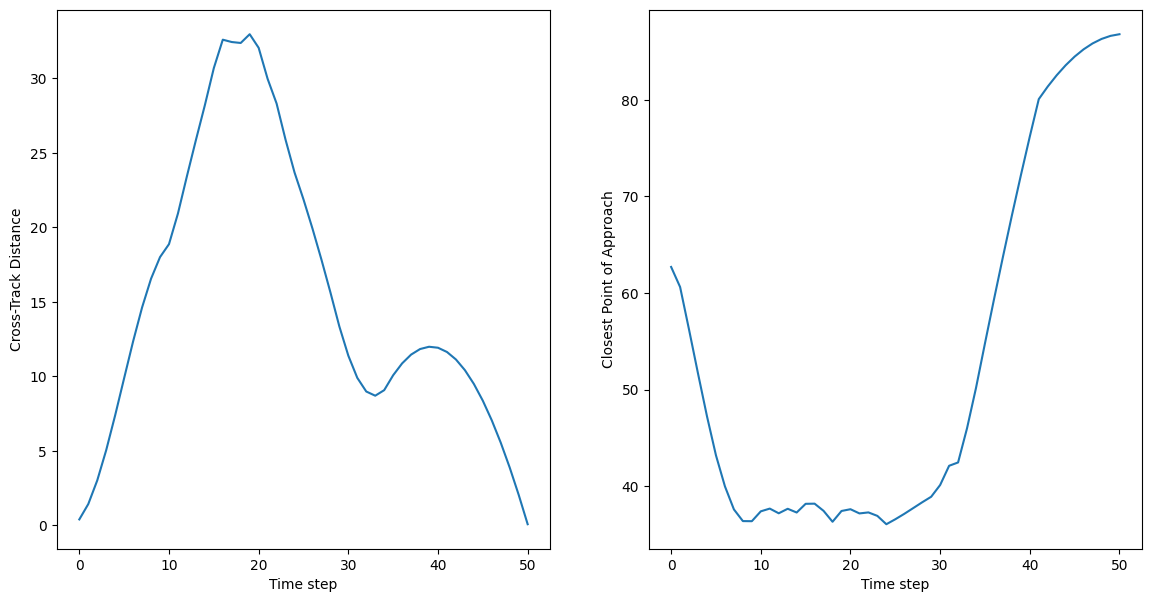

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (14,7))
sb.lineplot(ctdlist[2], ax = ax[0])
sb.lineplot(cpa_list[0], ax = ax[1])
ax[0].set_xlabel('Time step')
ax[0].set_ylabel('Cross-Track Distance')
ax[1].set_xlabel('Time step')
ax[1].set_ylabel('Closest Point of Approach')

